# Phase 2: Feature Expansion for F10.7 Forecasting

## Objective
Evaluate how adding new data inputs affects the accuracy of a 7-day ahead forecast of daily F10.7 values.  
We will use a single model (Gradient Boosted Trees) and test step-by-step feature additions.

## Approach
1. **Baseline Setup**
   - Target: Daily F10.7, 7 days ahead
   - Validation: Walk-forward validation
   - Model: Gradient Boosted Trees (LightGBM)

2. **Feature Stages**
   - **Stage 0:** Persistence baseline (today’s flux → 7-day ahead)
   - **Stage 1:** Lag features (last 27 days)
   - **Stage 2:** + Persistence baseline as an input
   - **Stage 3:** + Rolling statistics (7-day & 27-day mean/std)
   - **Stage 4:** + Sunspot numbers (daily, 7-day & 27-day averages)
   - **Stage 5:** + Cycle/rotation indicators (27-day, 11-year harmonics)

3. **Evaluation**
   - Metrics: MAE, RMSE
   - Compare each stage against persistence baseline
   - Track whether new features provide consistent improvements across folds

## Expected Outcome
- Identify which features provide predictive value beyond persistence
- Quantify incremental improvements in 7-day F10.7 forecast accuracy
- Build a foundation for later exploration of additional inputs (geomagnetic indices, flares, EUV)


# Persistance Baseline

In [21]:
import pandas as pd
import numpy as np

# The local path to the F10.7 text file from Penticton, B.C., Canada
file_path = './datasets/f107.txt'

# Declare feature (col) names
cols = [
    "fluxdate", "fluxtime", "fluxjulian", "fluxcarrington",
    "fluxobsflux", "fluxadjflux", "fluxursi"
]

df = pd.read_csv(file_path, sep='\\s+', comment='#', header=None, names=cols)

# Convert date
df["date"] = pd.to_datetime(df["fluxdate"], format="%Y%m%d", errors="coerce")

# Force numeric conversion (turns strings like "000130.9" into 130.9 floats)
df["fluxadjflux"] = pd.to_numeric(df["fluxadjflux"], errors="coerce")

# Group by date (averaging the 3 daily measurements into one)
df = df.groupby("date", as_index=False)["fluxadjflux"].mean()

# Make a copy of the dataframe for 7 day prediction
data7 = df.copy()

# Create the target (label): flux 7 days in the future
    # EX: For date JAN 1: X -> JAN 1 Flux ; Y -> JAN 8 Flux
data7['target_flux'] = data7['fluxadjflux'].shift(-7)

# Add lag features: flux from the past 27 days (For LR)
for lag in range(1, 28):  # lag1 through lag27
    data7[f"lag{lag}"] = data7["fluxadjflux"].shift(lag)

# Drop the rows without labels (NaN) (happens because we are shifting the data by 7 days)
data7 = data7.dropna()

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Baseline persistence: predict that 7-day ahead flux = today's flux
data7["baseline_pred"] = data7["fluxadjflux"]

# Evaluate errors
mae = mean_absolute_error(data7["target_flux"], data7["baseline_pred"])
rmse = np.sqrt(mean_squared_error(data7["target_flux"], data7["baseline_pred"]))

print(f"Baseline 7-day Persistence MAE: {mae:.2f} sfu")
print(f"Baseline 7-day Persistence RMSE: {rmse:.2f} sfu")

Baseline 7-day Persistence MAE: 12.79 sfu
Baseline 7-day Persistence RMSE: 23.40 sfu


## Stage 1: Historical Data

### Objective
Evaluate how the number of historical lag features (past days of F10.7) impacts the accuracy of a 7-day ahead forecast.  

### Process Overview
1. **Data Preparation**
   - Source: Daily F10.7 adjusted flux values from `f107.txt` (Penticton, B.C., Canada).
   - Preprocessing:
     - Converted raw text into daily averages.
     - Created a target column (`target_flux`) = flux 7 days ahead.
     - Added lag features (`lag1 … lag27`) to represent historical context.
   - This ensures each row has today’s flux, yesterday’s flux, … up to 27 days back.

2. **Baseline Benchmark**
   - Persistence baseline = “7 days ahead = today’s flux”.
   - Errors measured using Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).

3. **Modeling Approach**
   - Model: Gradient Boosted Trees (LightGBM).
   - Validation: Time-aware splits rather than random shuffle.
   - Feature sets tested:
     - Lag 1 (yesterday only)
     - Lags 1–7 (past week)
     - Lags 1–27 (one solar rotation)
     - Lags 1–54 (two rotations)

4. **Cycle-Aware Evaluation**
   - To see how results depend on solar activity, we split the dataset into **solar cycles** using NOAA minima:
     - Cycle 23 partial (2004–2008)
     - Cycle 24 full (2008–2019)
     - Cycle 25 partial (2019–present)
   - Within each cycle:
     - Persistence baseline applied.
     - LightGBM trained on the first 80% of that cycle, tested on the last 20%.

---

## Persistence Baseline Results
- **Full dataset (2004–present):**
  - MAE ≈ 12.8 sfu
  - RMSE ≈ 23.4 sfu  
- Persistence is a strong benchmark: it works well in quiet periods but fails on sudden solar spikes.

## Extract Solar Cycles

To properly evaluate performance across different phases of solar activity, we aligned our dataset 
with official solar cycle boundaries.  

### Process
- Downloaded NOAA/NASA dataset: *"Minima and Maxima of Sunspot Number Cycles"*  
  ([NGDC](https://www.ngdc.noaa.gov/stp/space-weather/solar-data/solar-indices/sunspot-numbers/cycle-data/table_cycle-dates_maximum-minimum.txt))  
- Parsed **cycle minima** (start dates) from the text file.
- Identified the cycles overlapping our dataset:
  - **Cycle 23 minimum**: ~1996 (dataset covers only 2004–2008, partial cycle)
  - **Cycle 24 minimum**: ~2008 (full coverage in dataset)
  - **Cycle 25 minimum**: ~2019 (dataset covers 2019–present, partial cycle)

### Why
- F10.7 behavior differs strongly between solar minimum, solar maximum, and declining phases.  
- Persistence and ML models may perform very differently depending on which phase they are tested in.  
- By splitting evaluation by cycle, we avoid “averaging out” behavior across very different solar conditions.

---

## Cycle-Based Evaluation


In [19]:
import pandas as pd

# parse fixed-width file
colspecs = [(0,5), (5,13), (13,21), (21,29)]
names = ["cycle", "min_year", "max_year", "next_min_year"]

df_cycles = pd.read_fwf("datasets/solar_cycle_minmax.txt", colspecs=colspecs, names=names)

# clean
df_cycles = df_cycles[pd.to_numeric(df_cycles["cycle"], errors="coerce").notna()]
df_cycles["cycle"] = df_cycles["cycle"].astype(int)
df_cycles["min_year"] = pd.to_numeric(df_cycles["min_year"], errors="coerce")

# keep cycles 23–24, and manually add cycle 25 start
cycles = df_cycles[df_cycles["cycle"].isin([23,24])][["cycle","min_year"]].copy()
cycles.loc[len(cycles)] = [25, 2019.0]

# convert fractional year (e.g. 2008.9) to datetime
def year_fraction_to_date(yf):
    year = int(yf)
    frac = yf - year
    month = int(round(frac * 12)) or 1
    return pd.to_datetime(f"{year}-{month:02d}-01")

cycles["min_date"] = cycles["min_year"].apply(year_fraction_to_date)
print(cycles)


    cycle  min_year   min_date
41   23.0    1996.0 1996-01-01
42   24.0    2008.0 2008-01-01
2    25.0    2019.0 2019-01-01


In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import lightgbm as lgb

def evaluate_cycle(df, start_date, end_date, max_lag=27):
    # restrict data to the cycle window
    cycle_df = df[(df["date"] >= start_date) & (df["date"] < end_date)].copy()
    if cycle_df.empty:
        return None
    
    # drop NaNs from shifting
    cycle_df = cycle_df.dropna()

    # --- Persistence baseline ---
    mae_p = mean_absolute_error(cycle_df["target_flux"], cycle_df["fluxadjflux"])
    rmse_p = np.sqrt(mean_squared_error(cycle_df["target_flux"], cycle_df["fluxadjflux"]))

    # --- LightGBM model ---
    features = [f"lag{i}" for i in range(1, max_lag+1)]
    cycle_df = cycle_df.dropna(subset=features + ["target_flux"])
    split_idx = int(len(cycle_df) * 0.8)
    train, test = cycle_df.iloc[:split_idx], cycle_df.iloc[split_idx:]

    model = lgb.LGBMRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=5,
        random_state=42,
        verbose=-1
    )
    model.fit(train[features], train["target_flux"])
    pred = model.predict(test[features])

    mae_m = mean_absolute_error(test["target_flux"], pred)
    rmse_m = np.sqrt(mean_squared_error(test["target_flux"], pred))

    return mae_p, rmse_p, mae_m, rmse_m

# --- Run for cycles 23, 24, 25 ---
cycles = [
    (23, pd.to_datetime("2004-01-01"), pd.to_datetime("2008-01-01")),  # partial since your data starts 2004
    (24, pd.to_datetime("2008-01-01"), pd.to_datetime("2019-01-01")),
    (25, pd.to_datetime("2019-01-01"), data7["date"].max())
]

for c, start, end in cycles:
    results = evaluate_cycle(data7, start, end, max_lag=27)
    if results:
        mae_p, rmse_p, mae_m, rmse_m = results
        print(f"Cycle {c} ({start.date()} to {end.date()}):")
        print(f"  Persistence → MAE: {mae_p:.2f} | RMSE: {rmse_p:.2f}")
        print(f"  LightGBM(27 lags) → MAE: {mae_m:.2f} | RMSE: {rmse_m:.2f}")


Cycle 23 (2004-01-01 to 2008-01-01):
  Persistence → MAE: 10.51 | RMSE: 23.06
  LightGBM(27 lags) → MAE: 5.18 | RMSE: 6.60
Cycle 24 (2008-01-01 to 2019-01-01):
  Persistence → MAE: 11.30 | RMSE: 20.03
  LightGBM(27 lags) → MAE: 5.20 | RMSE: 9.22
Cycle 25 (2019-01-01 to 2025-09-11):
  Persistence → MAE: 16.29 | RMSE: 28.19
  LightGBM(27 lags) → MAE: 31.82 | RMSE: 43.37


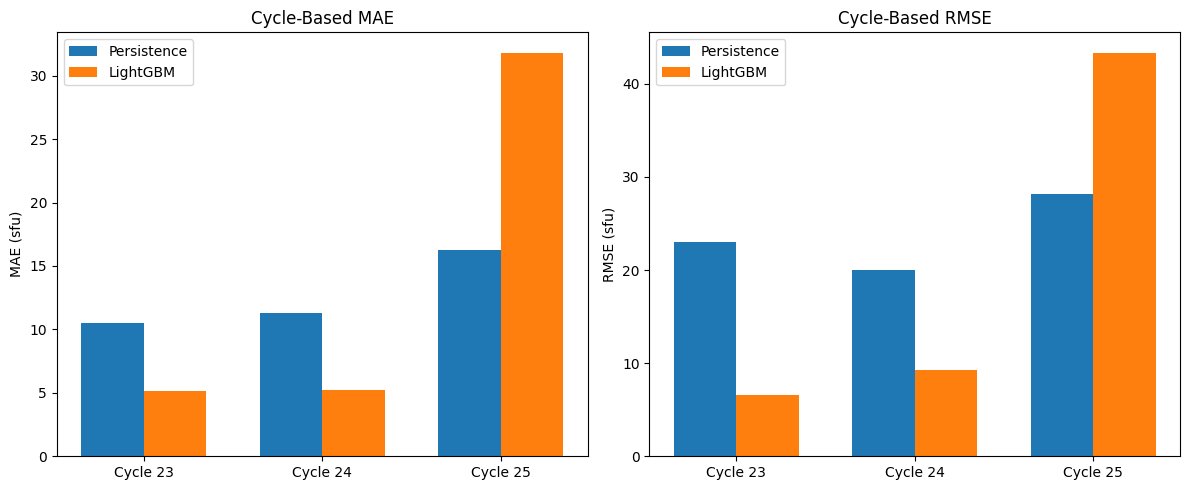

In [29]:
import matplotlib.pyplot as plt

# Cycle-based results (from your runs)
cycles = ["Cycle 23", "Cycle 24", "Cycle 25"]
mae_p = [10.51, 11.30, 16.29]
rmse_p = [23.06, 20.03, 28.19]
mae_m = [5.18, 5.20, 31.82]
rmse_m = [6.60, 9.22, 43.37]

x = range(len(cycles))
width = 0.35

fig, axs = plt.subplots(1, 2, figsize=(12,5))

# MAE
axs[0].bar([i-width/2 for i in x], mae_p, width, label="Persistence")
axs[0].bar([i+width/2 for i in x], mae_m, width, label="LightGBM")
axs[0].set_title("Cycle-Based MAE")
axs[0].set_xticks(x)
axs[0].set_xticklabels(cycles)
axs[0].set_ylabel("MAE (sfu)")
axs[0].legend()

# RMSE
axs[1].bar([i-width/2 for i in x], rmse_p, width, label="Persistence")
axs[1].bar([i+width/2 for i in x], rmse_m, width, label="LightGBM")
axs[1].set_title("Cycle-Based RMSE")
axs[1].set_xticks(x)
axs[1].set_xticklabels(cycles)
axs[1].set_ylabel("RMSE (sfu)")
axs[1].legend()

plt.tight_layout()
plt.show()


## Cycle-Based Evaluation

Before testing new input features, we checked how persistence and LightGBM perform across 
individual solar cycles. Segmenting the dataset this way is important, because solar activity 
(and thus forecast difficulty) changes dramatically between cycles. Without this segmentation, 
results averaged across all time periods can hide where models truly work or fail.

### Method
- Split dataset by solar cycle minima (NOAA/NASA):
  - **Cycle 23 (partial):** 2004–2008  
  - **Cycle 24 (full):** 2008–2019  
  - **Cycle 25 (partial):** 2019–present  
- In each cycle:
  - **Persistence:** today’s flux as 7-day forecast  
  - **LightGBM:** 27 lag features, trained on first 80% of the cycle, tested on the last 20%  

### Results
- **Cycle 23:** Persistence MAE=10.51 | RMSE=23.06; LightGBM MAE=5.18 | RMSE=6.60  
- **Cycle 24:** Persistence MAE=11.30 | RMSE=20.03; LightGBM MAE=5.20 | RMSE=9.22  
- **Cycle 25:** Persistence MAE=16.29 | RMSE=28.19; LightGBM MAE=31.82 | RMSE=43.37  

### Takeaways
- LightGBM clearly outperformed persistence during Cycles 23 and 24.  
- In Cycle 25, persistence held up better while LightGBM failed to generalize.  
- **Key Insight:** Restricting evaluation by cycle reveals patterns that global averages would miss.  
- Going forward, we will focus on **Cycle 24** as the main testbed for testing lag lengths and adding 
new input features, since it provides a complete cycle where the model is competitive.


## Lag Length Testing

Now that we know LightGBM performs well during Cycle 24, we use it as our testbed to measure 
how the number of historical lag features affects forecast accuracy.  

### Method
- Dataset restricted to **Cycle 24 (2008–2019)**.  
- Input features: past daily F10.7 values (`lag1 … lagN`).  
- Tested lag lengths:
  - **Lag 1** (yesterday only)  
  - **Lags 1–7** (past week)  
  - **Lags 1–27** (one solar rotation)  
  - **Lags 1–54** (two rotations)  
- Model: LightGBM regressor.  
- Validation: Chronological 80/20 split within Cycle 24.  

### Evaluation
For each lag configuration we will compute:
- **Mean Absolute Error (MAE)**  
- **Root Mean Squared Error (RMSE)**  

This will show whether more historical memory improves forecasts, and if there’s a point of diminishing returns.


In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb
import numpy as np

# extend lag features up to 54
for lag in range(28, 55):  # lag28 through lag54
    data7[f"lag{lag}"] = data7["fluxadjflux"].shift(lag)

# rebuild cycle24 with new columns
cycle24 = data7[(data7["date"] >= "2008-01-01") & (data7["date"] < "2019-01-01")].copy()


def evaluate_lags_cycle24(df, max_lag):
    features = [f"lag{i}" for i in range(1, max_lag+1)]
    df = df.dropna(subset=features + ["target_flux"])

    # chronological 80/20 split
    split_idx = int(len(df) * 0.8)
    train, test = df.iloc[:split_idx], df.iloc[split_idx:]

    X_train, y_train = train[features], train["target_flux"]
    X_test,  y_test  = test[features],  test["target_flux"]

    model = lgb.LGBMRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=5,
        random_state=42,
        verbose=-1
    )
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    return mae, rmse

# run tests for different lag lengths
for lag in [1, 7, 27, 54]:
    mae, rmse = evaluate_lags_cycle24(cycle24, lag)
    print(f"LightGBM (Cycle 24, Lag {lag}) → MAE: {mae:.2f} sfu | RMSE: {rmse:.2f} sfu")



LightGBM (Cycle 24, Lag 1) → MAE: 5.72 sfu | RMSE: 10.45 sfu
LightGBM (Cycle 24, Lag 7) → MAE: 5.41 sfu | RMSE: 9.89 sfu
LightGBM (Cycle 24, Lag 27) → MAE: 5.20 sfu | RMSE: 9.22 sfu
LightGBM (Cycle 24, Lag 54) → MAE: 5.84 sfu | RMSE: 10.54 sfu


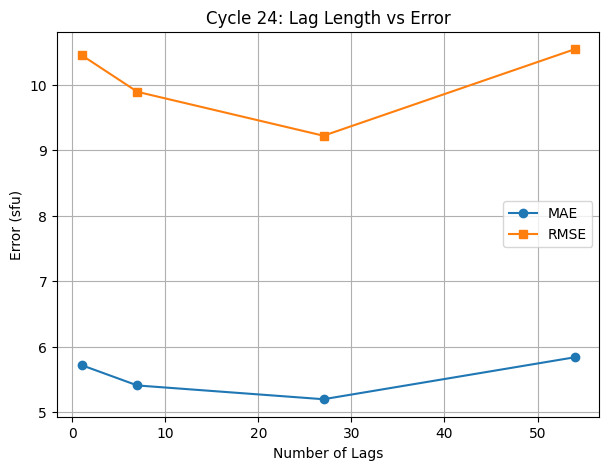

In [30]:
# Lag test results (Cycle 24)
lags = [1, 7, 27, 54]
mae_lag = [5.72, 5.41, 5.20, 5.84]
rmse_lag = [10.45, 9.89, 9.22, 10.54]

plt.figure(figsize=(7,5))
plt.plot(lags, mae_lag, marker="o", label="MAE")
plt.plot(lags, rmse_lag, marker="s", label="RMSE")
plt.title("Cycle 24: Lag Length vs Error")
plt.xlabel("Number of Lags")
plt.ylabel("Error (sfu)")
plt.legend()
plt.grid(True)
plt.show()


## Lag Length Results (Cycle 24)

### Summary
We tested different amounts of historical memory to see how lag length affects 7-day forecasts 
using LightGBM during Cycle 24 (2008–2019).  

### Results
| Lag Length | MAE (sfu) | RMSE (sfu) |
|------------|-----------|------------|
| Lag 1 (yesterday)     | 5.72 | 10.45 |
| Lags 1–7 (1 week)     | 5.41 | 9.89  |
| Lags 1–27 (1 rotation) | **5.20** | **9.22** |
| Lags 1–54 (2 rotations) | 5.84 | 10.54 |

### Takeaways
- **Lag 1**: too little context, higher error.  
- **Lags 1–7**: modest improvement by adding a week of history.  
- **Lags 1–27**: best performance — one full solar rotation provides the strongest predictive signal.  
- **Lags 1–54**: performance worsens — extra lags add noise rather than useful information.  

**Conclusion:** One solar rotation (~27 days of history) gives the best balance of context and signal for 7-day F10.7 forecasts.  


## Adding Solar Cycle and Sunspot Features

So far we have only used historical F10.7 lags as input. This captures short-term autocorrelation, 
but fails to generalize well across solar cycles (as seen in Cycle 25). To improve forecasts, we 
now introduce additional features that provide broader context on solar activity.

### Candidate Features
- **Sunspot numbers (SSN):**  
  Strongly correlated with F10.7 and directly track solar activity. Adding daily SSN and 
  short rolling averages (7-day, 27-day) can help models anticipate changes in flux.

- **Cycle phase indicators:**  
  Encode the repeating nature of solar variability.  
  - 27-day solar rotation → `sin(2π * day/27)`, `cos(2π * day/27)`  
  - 11-year solar cycle → `sin(2π * day/(11*365))`, `cos(2π * day/(11*365))`  

### Why This Matters
- Persistence and lag-only models are blind to the *state of the solar cycle*.  
- By adding sunspot counts and phase indicators, the model gets information about where we are in 
  the broader solar process, improving stability across different cycles (especially Cycle 25).  

### Next Step
1. Load daily sunspot numbers (SILSO dataset).  
2. Merge with F10.7 by date.  
3. Create new features: daily SSN, rolling averages, and cycle phase harmonics.  
4. Re-run the Cycle 24 experiments (lags + sunspots) to see if errors improve compared to lags only.  
